In [2]:
# from: https://github.com/JisongXie/WOW/blob/master/wow.py

# -*- coding:utf-8 -*-

# -----------------------------------------------------------------------------
# python code of WOW algorithm(Steganography)
# -----------------------------------------------------------------------------
# Accoring to: http://dde.binghamton.edu/download/stego_algorithms/
# -----------------------------------------------------------------------------
# Publication: [1] Designing Steganographic Distortion Using Directional Filters, 
# V. Holub and J. Fridrich, to be presented at WIFS_12 IEEE International 
# Workshop on Information Forensics and Security
# -----------------------------------------------------------------------------

import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d


def WOW(cover, payload, params):
    # Input:  cover ... image
    #         payload ..... payload in bits per pixel
    # Output: stego ....... resulting image with embedded payload

    ## Get 2D wavelet filters - Daubechies 8
    # 1D high pass decomposition filter
    hpdf = np.matrix([[-0.0544158422, 0.3128715909, -0.6756307363, 0.5853546837, 0.0158291053, -0.2840155430, 
                    -0.0004724846, 0.1287474266, 0.0173693010, -0.0440882539, -0.0139810279, 0.0087460940,
                    0.0048703530, -0.0003917404, -0.0006754494, -0.0001174768]])
    # 1D low pass decomposition filter
    lpdf = np.matrix((-1) ** np.array(range(hpdf.shape[1])) * np.fliplr(hpdf).A)
    # construction of 2D wavelet filters
    F = []
    F.append(lpdf.T * hpdf)
    F.append(hpdf.T * lpdf)
    F.append(hpdf.T * hpdf)

    ## Get embedding costs
    # inicialization
    cover = cover.astype('float64')
    p = params
    wetCost = 10 ** 10
    sizeCover = cover.shape

    # add padding 
    padSize = np.max(np.concatenate([F[0].shape, F[1].shape, F[2].shape]))
    coverPadded = np.pad(cover, ((padSize, padSize), (padSize, padSize)), 'symmetric')

    # compute directional residual and suitability xi for each filter
    xi = []
    for fIndex in range(0, 3):
        # compute residual
        R = convolve2d(coverPadded, F[fIndex], 'same')

        # compute suitability
        xi.append(convolve2d(abs(R), np.rot90(abs(F[fIndex]), 2), 'same'))
        # correct the suitability shift if filter size is even
        if np.mod(np.size(F[fIndex], 0), 2) == 0:
            xi[fIndex] = np.roll(xi[fIndex], 1, axis=0)
            # xi[fIndex] = circshift(xi[fIndex], [1, 0])
        if np.mod(np.size(F[fIndex], 1), 2) == 0:
            xi[fIndex] = np.roll(xi[fIndex], 1, axis=1)
            # xi[fIndex] = circshift(xi[fIndex], [0, 1])
        
        # remove padding
        a_idx_s = int((np.size(xi[fIndex], 0) - sizeCover[0]) / 2)
        a_idx_e = int(np.size(xi[fIndex], 0) - (np.size(xi[fIndex], 0) - sizeCover[0]) / 2)
        b_idx_s = int((np.size(xi[fIndex], 1) - sizeCover[1]) / 2)
        b_idx_e = int(np.size(xi[fIndex], 1) - (np.size(xi[fIndex], 1) - sizeCover[1]) / 2)
        xi[fIndex] = xi[fIndex][a_idx_s:a_idx_e, b_idx_s:b_idx_e]
    
    # compute embedding costs \rho
    rho = (xi[0] ** p + xi[1] ** p + xi[2] ** p) ** (-1 / p)

    # adjust embedding costs
    rho[rho > wetCost] = wetCost    # threshold on the costs
    rho[np.isnan(rho)] = wetCost    # if all xi{} are zero threshold the cost
    rhoP1 = rho.copy()
    rhoM1 = rho.copy()
    rhoP1[cover == 255] = wetCost   # do not embed +1 if the pixel has max value
    rhoM1[cover == 0] = wetCost     # do not embed -1 if the pixel has min value

    # Embedding simulator
    stego = EmbeddingSimulator(cover, rhoP1, rhoM1, payload * cover.size, False)
    distortion_local = rho[cover != stego]
    distortion = np.sum(distortion_local)

    return stego, distortion


def EmbeddingSimulator(x, rhoP1, rhoM1, m, fixEmbeddingChanges):
    n = x.size
    m_lambda = calc_lambda(rhoP1, rhoM1, m, n)
    pChangeP1 = (np.exp(-m_lambda * rhoP1)) / (1 + np.exp(-m_lambda * rhoP1) + np.exp(-m_lambda * rhoM1))
    pChangeM1 = (np.exp(-m_lambda * rhoM1)) / (1 + np.exp(-m_lambda * rhoP1) + np.exp(-m_lambda * rhoM1))
    if fixEmbeddingChanges:
        np.random.seed(100)
    else:
        np.random.seed(int(time.time()))
    
    randChange = np.random.rand(*x.shape)
    y = x.copy()
    y[randChange < pChangeP1] = y[randChange < pChangeP1] + 1
    y[np.logical_and(randChange >= pChangeP1, randChange < (pChangeP1+pChangeM1))] = y[np.logical_and(randChange >= pChangeP1, randChange < (pChangeP1+pChangeM1))] - 1
    
    return y


def calc_lambda(rhoP1, rhoM1, message_length, n):
    l3 = 1e+3
    m3 = float(message_length + 1)
    iterations = 0
    while m3 > message_length:
        l3 = l3 * 2
        pP1 = np.exp(-l3 * rhoP1) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        pM1 = np.exp(-l3 * rhoM1) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        m3 = ternary_entropyf(pP1, pM1)
        iterations = iterations + 1
        if iterations > 10:
            m_lambda = l3
            return
    
    l1 = 0
    m1 = float(n)
    m_lambda = 0

    alpha = float(message_length) / n
    # limit search to 30 iterations
    # and require that relative payload embedded is roughly within 1/1000 of the required relative payload
    while float(m1-m3)/n > (alpha/1000.0) and (iterations < 30):
        m_lambda = l1 + (l3 - l1) / 2
        pP1 = (np.exp(-l3 * rhoP1)) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        pM1 = (np.exp(-l3 * rhoM1)) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        m2 = ternary_entropyf(pP1, pM1)
        if m2 < message_length:
            l3 = m_lambda
            m3 = m2
        else:
            l1 = m_lambda
            m1 = m2
        iterations = iterations + 1

    return m_lambda


def ternary_entropyf(pP1, pM1):
    eps = 3e-16
    p0 = 1 - pP1 - pM1
    P = np.concatenate([p0.flatten(order='F'), pP1.flatten(order='F'), pM1.flatten(order='F')])
    P[P == 0] = 1e-16       # clear warning: divide by zero encountered in log2
    H = - (P * np.log2(P))
    H[np.logical_or(P < eps, P > (1 - eps))] = 0
    Ht = sum(H)
    return Ht


"""if __name__ == '__main__':
    img_path = 'nijq.jpg'       # image path
    payload = 0.4               # payload(bits per pixel)
    params = -1                 # holder norm parameter
    
    cover = Image.open(img_path)
    if cover.mode == 'RGB':
        cover = cover.convert('L')
    cover = np.array(cover)
    stego, distortion = WOW(cover, payload, params)

    residual = (stego - cover.astype('float64') + 1)/2
    # print(residual)

    plt.subplot(121)
    plt.imshow(cover, cmap='gray')
    plt.subplot(122)
    plt.imshow(residual, cmap='gray')
    plt.show()"""

"if __name__ == '__main__':\n    img_path = 'nijq.jpg'       # image path\n    payload = 0.4               # payload(bits per pixel)\n    params = -1                 # holder norm parameter\n    \n    cover = Image.open(img_path)\n    if cover.mode == 'RGB':\n        cover = cover.convert('L')\n    cover = np.array(cover)\n    stego, distortion = WOW(cover, payload, params)\n\n    residual = (stego - cover.astype('float64') + 1)/2\n    # print(residual)\n\n    plt.subplot(121)\n    plt.imshow(cover, cmap='gray')\n    plt.subplot(122)\n    plt.imshow(residual, cmap='gray')\n    plt.show()"

In [11]:
img_path = r'C:\Users\Flavio\Bachelorarbeit\LSB\data_old\test\clean\04001.png'
cover = Image.open(img_path)

if cover.mode in ['RGB', 'RGBA']:
    cover = cover.convert('L')

cover = np.array(cover)
print("Bilddimensionen:", cover.shape)


Bilddimensionen: (512, 512)


C:\Users\Flavio\AppData\Local\Temp\ipykernel_31888\3923875694.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  rho = (xi[0] ** p + xi[1] ** p + xi[2] ** p) ** (-1 / p)


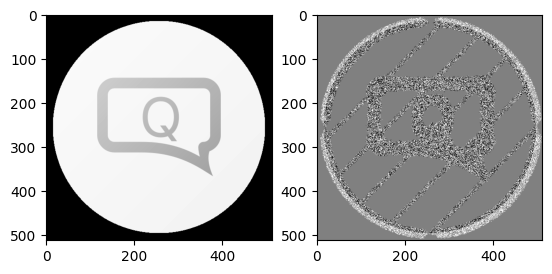

In [14]:
# mnist_images/image_0.png
img_path = r'C:\Users\Flavio\Bachelorarbeit\LSB\data_old\test\clean\04001.png'
payload = 0.4  # z. B. 0.4 Bits pro Pixel
params = -1    # Parameter für die Kostenberechnung (Standard: -1)

cover = Image.open(img_path)
if cover.mode in ['RGB', 'RGBA']:
    cover = cover.convert('L')
cover = np.array(cover)
stego, distortion = WOW(cover, payload, params)

residual = (stego - cover.astype('float64') + 1)/2
#print(residual)

plt.subplot(121)
plt.imshow(cover, cmap='gray')
plt.subplot(122)
plt.imshow(residual, cmap='gray')
plt.show()


In [ ]:
residual = (stego - cover.astype('float64') + 1)/2
plt.subplot(121)
plt.imshow(cover, cmap='gray')
plt.subplot(122)
plt.imshow(residual, cmap='gray')
plt.show()

In [4]:
input_folder = "mnist_images"
output_folder_normal = r"C:\Users\Flavio\Bachelorarbeit\LSB\datalol\normal"
output_folder_stego = r"C:\Users\Flavio\Bachelorarbeit\LSB\datalol\stego"
    
main(input_folder, output_folder_normal, output_folder_stego)

Fertig! Es wurden 35000 Bilder steganographisch verändert und 35000 Bilder unverändert gespeichert.
